In [2]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "/Users/ASUS/Desktop/Data Science Course Work/Group Project/model training/imputed_data/FRESH/FRESH_season1_imputed.csv"
df = pd.read_csv(file_path, na_values=["NA", ""],encoding="utf-8")# Missing values includes "NA" and ""

# Display basic information about the dataset
print("Dataset Info:")
df.info()

# Display the first 5 rows
print("\nFirst 5 Rows:")
print(df.head())

# counting missing values
print("\nMissing Values Count:")
print(df.isnull().sum().sum())

# Check for duplicates
print("\nNumber of Duplicate Rows:")
print(df.duplicated().sum())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Columns: 4214 entries, Sample_ID to 2499.5nm
dtypes: float64(4213), object(1)
memory usage: 1.3+ MB

First 5 Rows:
  Sample_ID  Nitrogen  Phosphorus  Potassium  Calcium  Magnesium  Sulfur  \
0    S01.01      5.03        0.37       9.57     1.65       0.48    0.20   
1    S01.02      5.40        0.36       9.57     2.22       0.62    0.20   
2    S01.03      5.27        0.37       8.92     1.91       0.53    0.20   
3    S01.04      4.89        0.24       8.80     1.05       0.39    0.23   
4    S01.05      5.14        0.28       9.14     1.21       0.30    0.21   

   Manganese  Boron   Zinc  ...    2495nm  2495.5nm    2496nm  2496.5nm  \
0       62.0   35.0  195.0  ...  0.013679  0.013660  0.013640  0.013618   
1       66.0   35.0  211.0  ...  0.013453  0.013451  0.013449  0.013447   
2       39.0   35.0  189.0  ...  0.019324  0.019295  0.019264  0.019233   
3      416.0   42.0   70.5  ...  0.018365  0

In [3]:
#import pandas as pd
# Ensure column names are treated as strings
df.columns = df.columns.astype(str)

# Set the starting index for input features (e.g., 14th column, zero-based index is 13)
start_index = 14  # starts at the 14th column

# Extract all spectral data columns
input_features = df.iloc[:, start_index:]

# Get the list of spectral column indices
wavelengths = list(input_features.columns)

# Set aggregation interval (every 8 nm = 16 columns)
group_size = 16
aggregated_features = {}

# Loop through spectral data in groups of 16 columns
for i in range(0, len(wavelengths), group_size):
    group_cols = wavelengths[i:i+group_size]  # Select 16 columns in the current group
    if len(group_cols) < group_size:
        break  # Stop if the last group has fewer than 16 columns
    
    # Create a new column name based on index positions (e.g., "Col_14-Col_29")
    #new_col_name = f"Col_{start_index + i}-Col_{start_index + i + group_size - 1}"
    
    # Create a new column name based on the first and last column names in the group
    new_col_name = f"{group_cols[0]}-{group_cols[-1]}"

    # Compute the mean across the selected columns and store the result
    aggregated_features[new_col_name] = input_features[group_cols].mean(axis=1)

# Keep the original output variables (first 14 columns)
output_variables = df.iloc[:, :start_index]

# Create a new DataFrame with original output variables + aggregated input features
aggregated_df = pd.concat([output_variables, pd.DataFrame(aggregated_features)], axis=1)

# Display the first few rows of the processed DataFrame
print(aggregated_df.head())

# Save the processed CSV file (optional)
output_path = "/Users/ASUS/Desktop/Data Science Course Work/Group Project/model training/imputed_data/FRESH/FRESH_season1_aggregated.csv"
aggregated_df.to_csv(output_path, index=False)
print(f"Processed file saved to {output_path}")


  Sample_ID  Nitrogen  Phosphorus  Potassium  Calcium  Magnesium  Sulfur  \
0    S01.01      5.03        0.37       9.57     1.65       0.48    0.20   
1    S01.02      5.40        0.36       9.57     2.22       0.62    0.20   
2    S01.03      5.27        0.37       8.92     1.91       0.53    0.20   
3    S01.04      4.89        0.24       8.80     1.05       0.39    0.23   
4    S01.05      5.14        0.28       9.14     1.21       0.30    0.21   

   Manganese  Boron   Zinc  ...  2416nm-2423.5nm  2424nm-2431.5nm  \
0       62.0   35.0  195.0  ...         0.018809         0.018077   
1       66.0   35.0  211.0  ...         0.016454         0.016014   
2       39.0   35.0  189.0  ...         0.026321         0.025329   
3      416.0   42.0   70.5  ...         0.029321         0.027751   
4      445.0   41.0  157.0  ...         0.027396         0.026117   

   2432nm-2439.5nm  2440nm-2447.5nm  2448nm-2455.5nm  2456nm-2463.5nm  \
0         0.017356         0.016654         0.016033   

In [ ]:
```python
# V1: Use PLS for dimensionality reduction; use LassoCV for hyperparameter tuning with 5-fold cross-validation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LassoCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Remove the first column (Sample_ID)
df_numeric = aggregated_df

# Define features X and target Y
X = aggregated_df.iloc[:, 14:].values  # X: spectral data from column 15 onwards
Y = aggregated_df.iloc[:, 1:14].values  # Y: columns 2 to 14 (nitrogen to chloride)

wavelengths = df_numeric.columns[14:]  # wavelength names
targets = df_numeric.columns[1:14]     # nutrient names

# Set the number of PLS components
n_components = min(X.shape[1], Y.shape[1])  # choose the smaller dimension of X and Y
pls = PLSRegression(n_components=n_components)

# PLS dimensionality reduction
X_pls = pls.fit_transform(X, Y)[0]

# Set up LassoCV wrapped in a MultiOutputRegressor for multi-target regression
lasso = MultiOutputRegressor(
    LassoCV(alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)
)

# Prepare lists to store metrics for each fold
mse_list = []
r2_list = []
rmse_list = []
rpd_list = []

# Using 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X_pls)):
    print(f"\n=== Fold {fold+1} ===")
    
    # Data splitting
    X_train, X_test = X_pls[train_index], X_pls[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Train the LassoCV model
    lasso.fit(X_train, Y_train)
    Y_pred = lasso.predict(X_test)
    
    # Calculate MSE, R², and RMSE
    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    
    # Calculate RPD (Ratio of Performance to Deviation)
    std_dev = np.std(Y_test, axis=0, ddof=1)
    rpd = std_dev / rmse
    
    # Record results for each fold
    mse_list.append(mse)
    r2_list.append(r2)
    rmse_list.append(rmse)
    rpd_list.append(rpd)
    
    # Print metrics for each target variable
    for i, val in enumerate(r2):
        print(f"R² for target variable {targets[i]}: {val:.4f}")
    for i, val in enumerate(rmse):
        print(f"RMSE for target variable {targets[i]}: {val:.4f}")
    for i, val in enumerate(rpd):
        print(f"RPD for target variable {targets[i]}: {val:.4f}")

# Calculate 5-fold averages for each target variable
mean_mse = np.mean(mse_list, axis=0)
mean_r2 = np.mean(r2_list, axis=0)
mean_rmse = np.mean(rmse_list, axis=0)
mean_rpd = np.mean(rpd_list, axis=0)

# Compile results into a DataFrame and display
results_df = pd.DataFrame({
    "Nutrient": targets,
    "R²": mean_r2,
    "RMSE": mean_rmse,
    "RPD": mean_rpd
})
print("\n=== 5-Fold Cross-Validation Results ===")
print(results_df)
```



=== Fold 1 ===
R² for target variable Nitrogen: 0.4883
R² for target variable Phosphorus: 0.2310
R² for target variable Potassium: 0.7434
R² for target variable Calcium: 0.6114
R² for target variable Magnesium: 0.1978
R² for target variable Sulfur: 0.3922
R² for target variable Manganese: 0.1736
R² for target variable Boron: -0.5846
R² for target variable Zinc: -0.1763
R² for target variable Copper: -0.2003
R² for target variable Aluminum: -0.7855
R² for target variable Sodium: -0.1182
R² for target variable Chloride: 0.6551
RMSE for target variable Nitrogen: 0.5530
RMSE for target variable Phosphorus: 0.0617
RMSE for target variable Potassium: 1.0060
RMSE for target variable Calcium: 0.2278
RMSE for target variable Magnesium: 0.2741
RMSE for target variable Sulfur: 0.0242
RMSE for target variable Manganese: 260.4488
RMSE for target variable Boron: 4.2659
RMSE for target variable Zinc: 46.1063
RMSE for target variable Copper: 4.1334
RMSE for target variable Aluminum: 102.3148
RMSE for

In [ ]:
```python
# Use MultiTaskLassoCV because different nutritional components of potatoes are often influenced by similar spectral bands, and there may be correlations among these components.
# V2: First perform PLS dimensionality reduction, then tune parameters via MultiTaskLassoCV; implement k-fold CV and select alpha
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Delete the first column (Sample_ID)
df_numeric = aggregated_df

# Define X and Y
X = aggregated_df.iloc[:, 14:].values  # X: spectral data from column 15 onwards
Y = aggregated_df.iloc[:, 1:14].values  # Y: columns 2 to 14 (nitrogen to chloride)

wavelengths = df_numeric.columns[14:]  # wavelength names
targets = df_numeric.columns[1:14]     # nutrient names

# Set the number of PLS components
n_components = min(X.shape[1], Y.shape[1], 20)  # choose the smaller dimension of X, Y, up to 20
pls = PLSRegression(n_components=n_components)

# PLS dimensionality reduction
X_pls = pls.fit_transform(X, Y)[0]

# Use MultiTaskLassoCV to select the optimal alpha (regularization parameter)
# alphas = 100 values logarithmically spaced from 1e-4 to 1e1
lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store metrics
mse_list, r2_list, rmse_list, rpd_list = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_pls)):
    print(f"\n=== Fold {fold+1} ===")
    
    # Split training and test data
    X_train, X_test = X_pls[train_idx], X_pls[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Train the MultiTaskLassoCV model
    lasso.fit(X_train, Y_train)
    Y_pred = lasso.predict(X_test)  # Predict on the test set
    
    print(f"Best alpha for Fold {fold+1}: {lasso.alpha_}")
    
    # Calculate MSE, R², and RMSE
    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    
    # Calculate RPD (Ratio of Performance to Deviation)
    std_dev = np.std(Y_train, axis=0, ddof=1)
    rpd = std_dev / rmse
    
    # Store results
    mse_list.append(mse)
    r2_list.append(r2)
    rmse_list.append(rmse)
    rpd_list.append(rpd)
    
    # Print metrics for each target variable
    for i, val in enumerate(r2):
        print(f"R² for target variable {targets[i]}: {val:.4f}")
    for i, val in enumerate(rmse):
        print(f"RMSE for target variable {targets[i]}: {val:.4f}")
    for i, val in enumerate(rpd):
        print(f"RPD for target variable {targets[i]}: {val:.4f}")

# Calculate 5-fold averages
mean_mse = np.mean(mse_list, axis=0)
mean_r2 = np.mean(r2_list, axis=0)
mean_rmse = np.mean(rmse_list, axis=0)
mean_rpd = np.mean(rpd_list, axis=0)

# Display results
results_df = pd.DataFrame({
    "Nutrient": targets,
    "R²": mean_r2,
    "RMSE": mean_rmse,
    "RPD": mean_rpd
})
print("\n=== 5-Fold Cross-Validation Results ===")
print(results_df)
```



=== Fold 1 ===
Best alpha for Fold 1: 10.0
R² for target variable Nitrogen: 0.6539
R² for target variable Phosphorus: 0.0513
R² for target variable Potassium: 0.7954
R² for target variable Calcium: 0.4975
R² for target variable Magnesium: 0.2934
R² for target variable Sulfur: 0.6472
R² for target variable Manganese: 0.1154
R² for target variable Boron: -0.6650
R² for target variable Zinc: -0.0378
R² for target variable Copper: -0.1305
R² for target variable Aluminum: -0.8383
R² for target variable Sodium: 0.1181
R² for target variable Chloride: 0.5130
RMSE for target variable Nitrogen: 0.4547
RMSE for target variable Phosphorus: 0.0685
RMSE for target variable Potassium: 0.8983
RMSE for target variable Calcium: 0.2591
RMSE for target variable Magnesium: 0.2572
RMSE for target variable Sulfur: 0.0184
RMSE for target variable Manganese: 269.4685
RMSE for target variable Boron: 4.3728
RMSE for target variable Zinc: 43.3085
RMSE for target variable Copper: 4.0116
RMSE for target variable 

In [ ]:
```python
# V3: PLS + MultiTaskLassoCV, incorporate Random Forest Regressor and use Weighted Averaging Ensemble
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
# df_numeric = aggregated_df

# Define X and Y
X = aggregated_df.iloc[:, 14:].values  # X: spectral data from column 15 onwards
Y = aggregated_df.iloc[:, 1:14].values  # Y: columns 2 to 14 (nitrogen to chloride)

wavelengths = aggregated_df.columns[14:]  # wavelength names
targets = aggregated_df.columns[1:14]     # nutrient names

# Set the number of PLS components
n_components = min(X.shape[1], Y.shape[1], 20)  # choose the smaller dimension of X, Y, up to 20
pls = PLSRegression(n_components=n_components)

# PLS dimensionality reduction
X_pls = pls.fit_transform(X, Y)[0]

# Initialize MultiTaskLassoCV and RandomForestRegressor
lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, r2_list, rmse_list, rpd_list = [], [], [], []

for train_idx, test_idx in kf.split(X_pls):
    X_train, X_test = X_pls[train_idx], X_pls[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Train MultiTaskLassoCV
    lasso.fit(X_train, Y_train)
    Y_pred_lasso = lasso.predict(X_test)
    
    # Train RandomForestRegressor
    rf.fit(X_train, Y_train)
    Y_pred_rf = rf.predict(X_test)
    
    # Weighted averaging (weights adjustable)
    Y_pred = 0.8 * Y_pred_lasso + 0.2 * Y_pred_rf
    
    # Calculate metrics
    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    std_dev = np.std(Y_test, axis=0, ddof=1)
    rpd = std_dev / rmse
    
    mse_list.append(mse)
    r2_list.append(r2)
    rmse_list.append(rmse)
    rpd_list.append(rpd)

# Calculate 5-fold averages
mean_mse = np.mean(mse_list, axis=0)
mean_r2 = np.mean(r2_list, axis=0)
mean_rmse = np.mean(rmse_list, axis=0)
mean_rpd = np.mean(rpd_list, axis=0)

# Compile results
results_df = pd.DataFrame({
    "Nutrient": targets,
    "R²": mean_r2,
    "RMSE": mean_rmse,
    "RPD": mean_rpd
})

print("\n=== Weighted Averaging Ensemble Results ===")
print(results_df)
```



=== Weighted Averaging Ensemble Results ===
      Nutrient        R²        RMSE       RPD
0     Nitrogen  0.767018    0.453344  2.329555
1   Phosphorus  0.330208    0.085745  1.354867
2    Potassium  0.721375    1.088009  2.108219
3      Calcium  0.246551    0.292174  1.550856
4    Magnesium  0.560271    0.208071  1.667082
5       Sulfur  0.456784    0.028630  1.601162
6    Manganese  0.492347  238.355966  1.739370
7        Boron -0.397337    4.848412  0.963902
8         Zinc  0.168747   44.215726  1.248523
9       Copper -0.165225    4.893095  1.029977
10    Aluminum -0.737922  122.903918  0.887958
11      Sodium  0.063108    0.011124  1.123167
12    Chloride -0.527407    0.546573  1.404590


In [ ]:
```python
# V3: PLS + MultiTaskLassoCV + RandomForestRegressor (Weighted Averaging Ensemble)
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define X and Y
X = aggregated_df.iloc[:, 14:].values  # spectral data from column 15 onwards
Y = aggregated_df.iloc[:, 1:14].values  # columns 2 to 14 (nitrogen to chloride)

wavelengths = aggregated_df.columns[14:]  # wavelength names
targets = aggregated_df.columns[1:14]     # nutrient names

# Initialize scalers for X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Standardize X and Y
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# PLS dimensionality reduction
n_components = min(X.shape[1], Y.shape[1], 20)  # choose up to 20 components
pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X, Y)[0]  # transform X with PLS

# Initialize MultiTaskLassoCV and RandomForestRegressor
lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics
mse_list, r2_list, rmse_list, rpd_list = [], [], [], []

for train_idx, test_idx in kf.split(X):
    # Split data for PLS (standardized) and RF (original scale)
    X_train_pls, X_test_pls = X_pls[train_idx], X_pls[test_idx]
    X_train_rf, X_test_rf = X[train_idx], X[test_idx]
    Y_train_scaled, Y_test_scaled = Y_scaled[train_idx], Y_scaled[test_idx]
    
    # Train MultiTaskLassoCV on PLS-transformed data
    lasso.fit(X_train_pls, Y_train_scaled)
    Y_pred_lasso_scaled = lasso.predict(X_test_pls)
    
    # Train RandomForestRegressor on original data
    rf.fit(X_train_rf, Y_train_scaled)
    Y_pred_rf_scaled = rf.predict(X_test_rf)
    
    # Inverse-transform predictions to original scale
    Y_pred_lasso = scaler_Y.inverse_transform(Y_pred_lasso_scaled)
    Y_pred_rf = scaler_Y.inverse_transform(Y_pred_rf_scaled)
    
    # Weighted averaging (e.g., 90% Lasso + 10% RF)
    Y_pred = 0.9 * Y_pred_lasso + 0.1 * Y_pred_rf
    
    # Calculate metrics
    mse = mean_squared_error(Y[test_idx], Y_pred, multioutput='raw_values')
    r2 = r2_score(Y[test_idx], Y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    std_dev = np.std(Y[test_idx], axis=0, ddof=1)
    rpd = std_dev / rmse
    
    # Store metrics
    mse_list.append(mse)
    r2_list.append(r2)
    rmse_list.append(rmse)
    rpd_list.append(rpd)

# Compute 5-fold average metrics
mean_mse = np.mean(mse_list, axis=0)
mean_r2 = np.mean(r2_list, axis=0)
mean_rmse = np.mean(rmse_list, axis=0)
mean_rpd = np.mean(rpd_list, axis=0)

# Compile and display results
results_df = pd.DataFrame({
    "Nutrient": targets,
    "R²": mean_r2,
    "RMSE": mean_rmse,
    "RPD": mean_rpd
})

print("\n=== Weighted Averaging Ensemble Results ===")
print(results_df)
```



=== Weighted Averaging Ensemble Results ===
      Nutrient        R²        RMSE       RPD
0     Nitrogen  0.670162    0.509375  2.217561
1   Phosphorus  0.401725    0.082153  1.470862
2    Potassium  0.586443    1.219843  2.031608
3      Calcium  0.095926    0.337193  1.292649
4    Magnesium  0.504809    0.217810  1.585365
5       Sulfur  0.393419    0.030584  1.503879
6    Manganese  0.525207  233.592490  1.697735
7        Boron -0.124772    4.443401  1.081590
8         Zinc -0.015804   48.465163  1.103211
9       Copper -0.144866    4.831276  1.071793
10    Aluminum -0.680969  120.795661  0.905747
11      Sodium -0.070212    0.011854  1.042684
12    Chloride -0.244757    0.553568  1.299349


In [ ]:
```python
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Load data
# -----------------------------
X_all   = aggregated_df.iloc[:, 14:].values   # spectral features from column 15 onwards
Y_all   = aggregated_df.iloc[:, 1:14].values  # nutrient labels from columns 2 to 14
targets = aggregated_df.columns[1:14]          # nutrient names

# -----------------------------
# 2. Parameter settings
# -----------------------------
n_components = min(X_all.shape[1], Y_all.shape[1], 20)  # choose up to 20 PLS components
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV splitter

# Lists to store metrics for each fold
mse_list, r2_list, rmse_list, rpd_list = [], [], [], []

# -----------------------------
# 3. 5-Fold cross-validation (no data leakage)
# -----------------------------
for train_idx, test_idx in kf.split(X_all):
    # ---- Split train / test
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    Y_train, Y_test = Y_all[train_idx], Y_all[test_idx]

    # ---- Fit/transform StandardScaler on training set
    scaler_X = StandardScaler().fit(X_train)
    scaler_Y = StandardScaler().fit(Y_train)
    X_train_s = scaler_X.transform(X_train)
    X_test_s  = scaler_X.transform(X_test)
    Y_train_s = scaler_Y.transform(Y_train)
    
    # ---- Fit/transform PLS on training set
    pls = PLSRegression(n_components=n_components)
    X_train_pls = pls.fit_transform(X_train_s, Y_train_s)[0]
    X_test_pls  = pls.transform(X_test_s)

    # ---- Train MultiTaskLassoCV on PLS-transformed training data
    lasso = MultiTaskLassoCV(
        alphas=np.logspace(-4, 1, 100),
        cv=5,
        random_state=42
    )
    lasso.fit(X_train_pls, Y_train_s)
    Y_pred_lasso_s = lasso.predict(X_test_pls)

    # ---- Train RandomForestRegressor on original training data
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, Y_train_s)
    Y_pred_rf_s = rf.predict(X_test)

    # ---- Inverse-transform predictions to original scale
    Y_pred_lasso = scaler_Y.inverse_transform(Y_pred_lasso_s)
    Y_pred_rf     = scaler_Y.inverse_transform(Y_pred_rf_s)

    # ---- Weighted averaging ensemble (e.g., 90% Lasso + 10% RF)
    Y_pred = 0.9 * Y_pred_lasso + 0.1 * Y_pred_rf

    # ---- Compute evaluation metrics
    mse_vals  = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2_vals   = r2_score(Y_test, Y_pred, multioutput='raw_values')
    rmse_vals = np.sqrt(mse_vals)
    std_dev   = np.std(Y_test, axis=0, ddof=1)
    rpd_vals  = std_dev / rmse_vals

    mse_list.append(mse_vals)
    r2_list.append(r2_vals)
    rmse_list.append(rmse_vals)
    rpd_list.append(rpd_vals)

# -----------------------------
# 4. Compile & display results
# -----------------------------
mean_mse   = np.mean(mse_list,   axis=0)
mean_r2    = np.mean(r2_list,    axis=0)
mean_rmse  = np.mean(rmse_list,  axis=0)
mean_rpd   = np.mean(rpd_list,   axis=0)

results_df = pd.DataFrame({
    "Nutrient": targets,
    "R²":       mean_r2,
    "RMSE":     mean_rmse,
    "RPD":      mean_rpd
})

print("\n=== Weighted Averaging Ensemble Results ===")
print(results_df)

print("\n=== Overall Performance Metrics ===")
print(f"Average R²:   {mean_r2.mean():.4f}")
print(f"Average RMSE: {mean_rmse.mean():.4f}")
print(f"Average RPD:  {mean_rpd.mean():.4f}")
```



=== Weighted Averaging Ensemble Results ===
      Nutrient        R²        RMSE       RPD
0     Nitrogen  0.664603    0.538850  2.086649
1   Phosphorus  0.285296    0.090167  1.286241
2    Potassium  0.545888    1.324921  1.826610
3      Calcium -0.234537    0.380966  1.172355
4    Magnesium  0.482075    0.224363  1.572099
5       Sulfur  0.321407    0.032622  1.399331
6    Manganese  0.466648  249.718073  1.569555
7        Boron -0.196937    4.554445  1.024512
8         Zinc  0.163477   45.022572  1.213696
9       Copper -0.249871    4.947302  1.016545
10    Aluminum -0.986080  131.576025  0.828044
11      Sodium -0.036858    0.011589  1.077849
12    Chloride -0.643727    0.616623  1.183641

=== Overall Performance Metrics ===
Average R²:   0.0447
Average RMSE: 33.7722
Average RPD:  1.3275


In [ ]:
```python
# V4: Use XGBoost to capture complex nonlinear relationships among features, and combine with Lasso via weighted averaging or stacking
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskLassoCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define X and Y
X = aggregated_df.iloc[:, 14:].values  # spectral features from column 15 onwards
Y = aggregated_df.iloc[:, 1:14].values  # nutrient labels from columns 2 to 14

wavelengths = aggregated_df.columns[14:]  # wavelength names
targets = aggregated_df.columns[1:14]     # nutrient names

# Initialize scalers
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Standardize X and Y
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# PLS dimensionality reduction
n_components = min(X.shape[1], Y.shape[1], 20)  # choose up to 20 PLS components
pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X, Y)[0]  # PLS transform

# Initialize MultiTaskLassoCV and XGBRegressor
lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)
xgb = XGBRegressor(
    n_estimators=150,      
    learning_rate=0.05,    
    max_depth=3,           
    min_child_weight=5,    
    subsample=0.7,         
    colsample_bytree=0.7,  
    reg_alpha=0.1,         
    reg_lambda=1,          
    random_state=42
)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics
mse_list, r2_list, rmse_list, rpd_list = [], [], [], []

for train_idx, test_idx in kf.split(X):
    # Split PLS data for Lasso and original data for XGBoost
    X_train_pls, X_test_pls = X_pls[train_idx], X_pls[test_idx]
    X_train_xgb, X_test_xgb = X[train_idx], X[test_idx]
    Y_train_scaled, Y_test_scaled = Y_scaled[train_idx], Y_scaled[test_idx]
    
    # Train MultiTaskLassoCV on PLS-transformed data
    lasso.fit(X_train_pls, Y_train_scaled)
    Y_pred_lasso_scaled = lasso.predict(X_test_pls)

    # Train XGBRegressor on original data
    xgb.fit(X_train_xgb, Y_train_scaled)
    Y_pred_xgb_scaled = xgb.predict(X_test_xgb)

    # Inverse-transform predictions to original scale
    Y_pred_lasso = scaler_Y.inverse_transform(Y_pred_lasso_scaled)
    Y_pred_xgb   = scaler_Y.inverse_transform(Y_pred_xgb_scaled)

    # Weighted averaging ensemble (e.g., 80% Lasso + 20% XGBoost)
    Y_pred = 0.8 * Y_pred_lasso + 0.2 * Y_pred_xgb

    # Compute evaluation metrics
    mse   = mean_squared_error(Y[test_idx], Y_pred, multioutput='raw_values')
    r2    = r2_score(Y[test_idx], Y_pred, multioutput='raw_values')
    rmse  = np.sqrt(mse)
    std_d = np.std(Y[test_idx], axis=0, ddof=1)
    rpd   = std_d / rmse

    mse_list.append(mse)
    r2_list.append(r2)
    rmse_list.append(rmse)
    rpd_list.append(rpd)

# Compute 5-fold average metrics
mean_mse   = np.mean(mse_list, axis=0)
mean_r2    = np.mean(r2_list, axis=0)
mean_rmse  = np.mean(rmse_list, axis=0)
mean_rpd   = np.mean(rpd_list, axis=0)

# Compile and display results
results_df = pd.DataFrame({
    "Nutrient": targets,
    "R²":       mean_r2,
    "RMSE":     mean_rmse,
    "RPD":      mean_rpd
})

print("\n=== Weighted Averaging Ensemble Results ===")
print(results_df)
```



=== Weighted Averaging Ensemble Results ===
      Nutrient        R²        RMSE       RPD
0     Nitrogen  0.660659    0.520488  2.120844
1   Phosphorus  0.409954    0.081845  1.458209
2    Potassium  0.556309    1.248933  2.017133
3      Calcium  0.088182    0.337988  1.287063
4    Magnesium  0.508355    0.216066  1.610386
5       Sulfur  0.347205    0.031728  1.445105
6    Manganese  0.538139  228.537707  1.761802
7        Boron -0.139381    4.466105  1.071106
8         Zinc -0.084407   50.013092  1.069406
9       Copper -0.158505    4.846289  1.071277
10    Aluminum -0.702582  119.969947  0.918446
11      Sodium -0.070062    0.011865  1.041951
12    Chloride -0.343990    0.562394  1.289913


In [ ]:
#Robust regression

In [ ]:
#adjust Weight
WEIGHTS_DICT = {
    "Nitrogen": 3.0,
    "Phosphorus": 3.0,
    "Potassium": 3.0,
    "Boron": 2.0,
    "Manganese": 2.0
}
#others:1

In [ ]:
# Way 1: Compute a weighted MSE so that key nutrients (e.g., Nitrogen, Phosphorus, Potassium) contribute more
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskLassoCV, RidgeCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# define weight
WEIGHTS_DICT = {
    "Nitrogen": 2.0,
    "Phosphorus": 2.0,
    "Potassium": 2.0,
    "Boron": 1.5,
    "Manganese": 1.2
}

def weighted_mse(y_true, y_pred, weights):
    errors = (y_true - y_pred) ** 2
    weighted_errors = errors * weights
    return np.mean(weighted_errors, axis=0)

# set X and Y
X = aggregated_df.iloc[:, 14:].values
Y = aggregated_df.iloc[:, 1:14].values 

wavelengths = aggregated_df.columns[14:] 
targets = aggregated_df.columns[1:14]  

# create weight
weights = np.array([WEIGHTS_DICT.get(nutrient, 1.0) for nutrient in targets])

# normalise X and Y
scaler_X, scaler_Y = StandardScaler(), StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# PLS dimensionality reduction
#n_components = min(X.shape[1], Y.shape[1], 5)
n_components = 8
pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_scaled, Y_scaled)[0]

# settings
lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)
# xgb = XGBRegressor(n_estimators=150, random_state=42, max_depth=3, min_child_weight=5,
#                    learning_rate=0.05, subsample=0.7, colsample_bytree=0.7, reg_alpha=0.1, reg_lambda=1)
xgb = XGBRegressor(n_estimators=200, random_state=42, max_depth=3, min_child_weight=5,
                   learning_rate=0.03, subsample=0.7, colsample_bytree=0.7, reg_alpha=0.1, reg_lambda=1)
meta_model = RidgeCV(alphas=np.logspace(-4, 1, 10))

# cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, r2_list, rmse_list, rpd_list = [], [], [], []

for train_idx, test_idx in kf.split(X):
    X_train_pls, X_test_pls = X_pls[train_idx], X_pls[test_idx]
    X_train_xgb, X_test_xgb = X[train_idx], X[test_idx]
    Y_train_scaled, Y_test_scaled = Y_scaled[train_idx], Y_scaled[test_idx]

    lasso.fit(X_train_pls, Y_train_scaled)
    Y_pred_lasso_scaled = lasso.predict(X_test_pls)

    xgb.fit(X_train_xgb, Y_train_scaled)
    Y_pred_xgb_scaled = xgb.predict(X_test_xgb)

    stacked_features = np.hstack([Y_pred_lasso_scaled, Y_pred_xgb_scaled])
    meta_model.fit(stacked_features, Y_test_scaled)
    Y_pred_meta_scaled = meta_model.predict(stacked_features)
    Y_pred_meta = scaler_Y.inverse_transform(Y_pred_meta_scaled)

    # calculate weighted MSE
    mse = weighted_mse(Y[test_idx], Y_pred_meta, weights)
    mse_list.append(mse)
    
    # calculate R²、RMSE、RPD
    r2 = r2_score(Y[test_idx], Y_pred_meta, multioutput='raw_values')
    rmse = np.sqrt(mse)
    std_dev = np.std(Y[test_idx], axis=0, ddof=1)
    rpd = std_dev / rmse
    
    r2_list.append(r2)
    rmse_list.append(rmse)
    rpd_list.append(rpd)

# calculate 5-Fold avg
mean_mse = np.mean(mse_list, axis=0)
mean_r2 = np.mean(r2_list, axis=0)
mean_rmse = np.mean(rmse_list, axis=0)
mean_rpd = np.mean(rpd_list, axis=0)

# plot result
results_df = pd.DataFrame({
    "Nutrient": targets,
    "Weighted MSE": mean_mse,
    "R²": mean_r2,
    "RMSE": mean_rmse,
    "RPD": mean_rpd
})

print("\n=== Weighted Loss Stacking Results ===")
print(results_df)

# calculate R²、RMSE 和 RPD avg
mean_r2_overall = np.mean(mean_r2)
mean_rmse_overall = np.mean(mean_rmse)
mean_rpd_overall = np.mean(mean_rpd)

#show outcome
print("\n=== Overall Performance Metrics ===")
print(f"Average R²: {mean_r2_overall:.4f}")
print(f"Average RMSE: {mean_rmse_overall:.4f}")
print(f"Average RPD: {mean_rpd_overall:.4f}")



=== Weighted Loss Stacking Results ===
      Nutrient  Weighted MSE        R²        RMSE       RPD
0     Nitrogen      0.341807  0.785854    0.563108  2.103771
1   Phosphorus      0.005612  0.773058    0.068078  1.861960
2    Potassium      1.707838  0.782408    1.247987  1.997275
3      Calcium      0.056045  0.643119    0.222735  2.047203
4    Magnesium      0.022855  0.759165    0.145557  2.659014
5       Sulfur      0.000512  0.702468    0.021035  2.336611
6    Manganese  38684.189694  0.744192  183.928011  2.337378
7        Boron     11.425256  0.557985    3.298314  1.436946
8         Zinc    928.866073  0.601837   29.774342  1.852131
9       Copper      7.491811  0.632356    2.598493  2.004300
10    Aluminum   4739.193120  0.537677   64.958782  1.839690
11      Sodium      0.000056  0.603111    0.006896  2.124447
12    Chloride      0.119126  0.644748    0.334718  2.237164

=== Overall Performance Metrics ===
Average R²: 0.6745
Average RMSE: 22.0899
Average RPD: 2.0645


In [ ]:
# Way 2: Balanced stacking of Lasso and XGBoost to leverage both models’ strengths,
# reducing the influence of trace elements and focusing on key nutrient predictions
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskLassoCV, RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Defining Nutrient Weights to prioritise key nutrients in model training and prediction
# WEIGHTS_DICT = {
#     "Nitrogen": 2.0,
#     "Phosphorus": 2.0,
#     "Potassium": 2.0,
#     "Boron": 1.5,
#     "Manganese": 1.2
# }

WEIGHTS_DICT = {
    "Nitrogen": 3.0,
    "Phosphorus": 3.0,
    "Potassium": 3.0,
    "Boron": 2.0,
    "Manganese": 2.0
}
# calculating weighted MSE function by penalising errors in high-priority nutrients more than others
def weighted_mse(y_true, y_pred, weights):
    errors = (y_true - y_pred) ** 2 # Compute squared errors
    weighted_errors = errors * weights # Apply weights to errors
    return np.mean(weighted_errors, axis=0) # Compute mean across all samples


# Preparing input data
X = aggregated_df.iloc[:, 14:].values  # Extract spectral data (features)
Y = aggregated_df.iloc[:, 1:14].values  # Extract nutrient concentrations (targets)

wavelengths = aggregated_df.columns[14:]  # Column names of spectral data
targets = aggregated_df.columns[1:14]  # Column names of nutrient data

# Generating weights. Create an array of weights, where each nutrient gets its predefined weight or 1.0(default) if not in WEIGHTS_DICT
weights = np.array([WEIGHTS_DICT.get(target, 1.0) for target in targets]) # Target is the name of the nutrient

# standardising features and targets, ensuring all features and targets are on the same scale, preventing bias in the models
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# PLS for dimensionality reduction(making it more interpretable and computationally efficient)
n_components = min(X.shape[1], Y.shape[1]) #selects the lowest value between the number of features, targets
pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_scaled, Y_scaled)[0]

# Define base models
lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 1, 100), cv=5, random_state=42) # Lasso: Automatically selects important spectral features using L1 regularization.
xgb = XGBRegressor(n_estimators=150, random_state=42, max_depth=3, 
                   min_child_weight=5, learning_rate=0.05, subsample=0.7, 
                   colsample_bytree=0.7, reg_alpha=0.1, reg_lambda=1) # XGBoost: A tree-based model, optimised for handling nonlinear relationships.
meta_model = RidgeCV(alphas=np.logspace(-4, 1, 10)) # RidgeCV serves as the meta-learner for stacked predictions, adding stability with L2 regularization.

# Initialise cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, r2_list, rmse_list, rpd_list = [], [], [], [] # Lists store metrics from each fold

# Train and evaluating the models
for train_idx, test_idx in kf.split(X):
    X_train_pls, X_test_pls = X_pls[train_idx], X_pls[test_idx]
    X_train_xgb, X_test_xgb = X[train_idx], X[test_idx]
    Y_train_scaled, Y_test_scaled = Y_scaled[train_idx], Y_scaled[test_idx]

    # Use PLS-transformed data for Lasso training
    lasso.fit(X_train_pls, Y_train_scaled)
    Y_pred_lasso_scaled = lasso.predict(X_test_pls)
    
    # Use raw data for XGBoost training
    xgb.fit(X_train_xgb, Y_train_scaled)
    Y_pred_xgb_scaled = xgb.predict(X_test_xgb)

    # Weighted stacking. Stacks predictions from both models, applying weights to prioritise key nutrients
    # combine the predictions from Lasso and XGBoost into a single stacked dataset
    # before stacking, each model's predictions are multiplied by a predefined weight(WEIGHTS_DICT)
    stacked_features = np.hstack([
        Y_pred_lasso_scaled * weights, 
        Y_pred_xgb_scaled * weights
    ]) # np.hstack: stacks the weighted predictions from both models horizontally, forming a new feature set for the meta-model
    
    # Train Meta-model
    # Ridge regression learns optimal weights for the stacked predictions
    meta_model.fit(stacked_features, Y_test_scaled)
    Y_pred_meta_scaled = meta_model.predict(stacked_features)
    Y_pred_meta = scaler_Y.inverse_transform(Y_pred_meta_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(Y[test_idx], Y_pred_meta, multioutput='raw_values')
    r2 = r2_score(Y[test_idx], Y_pred_meta, multioutput='raw_values')
    rmse = np.sqrt(mse)
    std_dev = np.std(Y[test_idx], axis=0, ddof=1)
    rpd = std_dev / rmse

    mse_list.append(mse)
    r2_list.append(r2)
    rmse_list.append(rmse)
    rpd_list.append(rpd)

# calculate mean
mean_mse = np.mean(mse_list, axis=0)
mean_r2 = np.mean(r2_list, axis=0)
mean_rmse = np.mean(rmse_list, axis=0)
mean_rpd = np.mean(rpd_list, axis=0)

# show outcome
results_df = pd.DataFrame({
    "Nutrient": targets,
    "MSE": mean_mse,
    "R²": mean_r2,
    "RMSE": mean_rmse,
    "RPD": mean_rpd
})

print("\n=== Weighted Stacked Features Results ===")
print(results_df)

# calculate matrix
overall_r2 = np.mean(mean_r2)
overall_rmse = np.mean(mean_rmse)
overall_rpd = np.mean(mean_rpd)

print("\n=== Overall Performance Metrics ===")
print(f"Average R²: {overall_r2:.4f}")
print(f"Average RMSE: {overall_rmse:.4f}")
print(f"Average RPD: {overall_rpd:.4f}")




=== Weighted Stacked Features Results ===
      Nutrient           MSE        R²        RMSE       RPD
0     Nitrogen      0.103303  0.868707    0.304961  3.957235
1   Phosphorus      0.001636  0.864298    0.036908  3.431229
2    Potassium      0.440856  0.881046    0.610438  4.435103
3      Calcium      0.033251  0.785413    0.169843  2.764540
4    Magnesium      0.012728  0.865872    0.110002  3.319100
5       Sulfur      0.000282  0.836445    0.015142  3.479188
6    Manganese  21529.984773  0.828098  137.775097  3.114928
7        Boron      5.241852  0.705166    2.113258  2.558491
8         Zinc    580.394463  0.733636   23.790587  2.298462
9       Copper      5.246347  0.753198    2.163695  2.419877
10    Aluminum   3824.575648  0.653516   57.738807  2.188511
11      Sodium      0.000041  0.698287    0.006149  2.100509
12    Chloride      0.069221  0.751419    0.256770  2.924337

=== Overall Performance Metrics ===
Average R²: 0.7865
Average RMSE: 17.3147
Average RPD: 2.9993


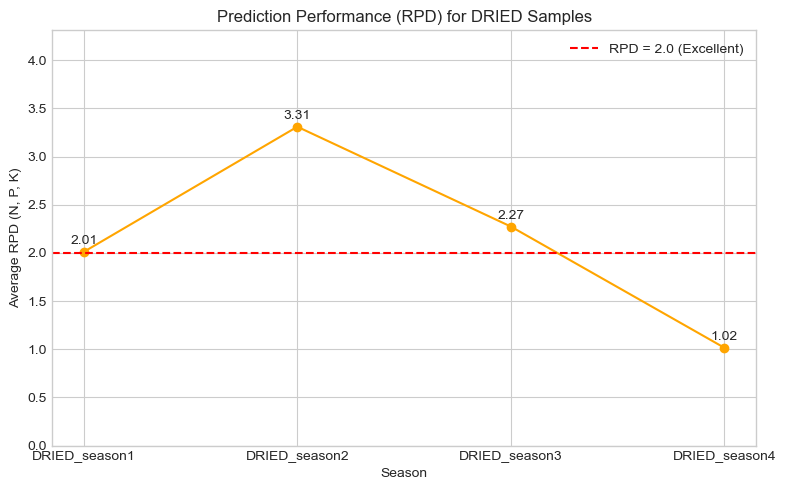

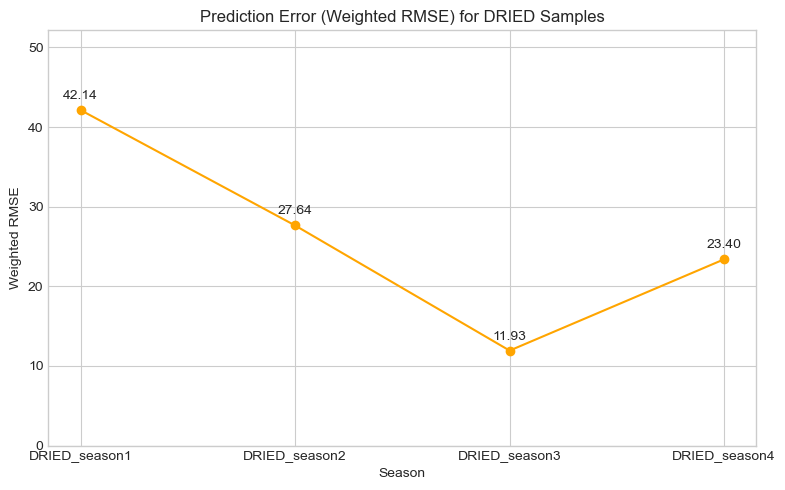

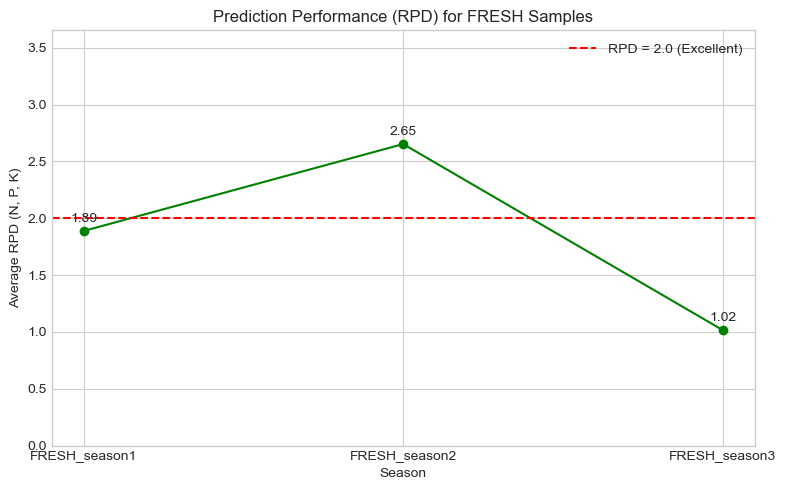

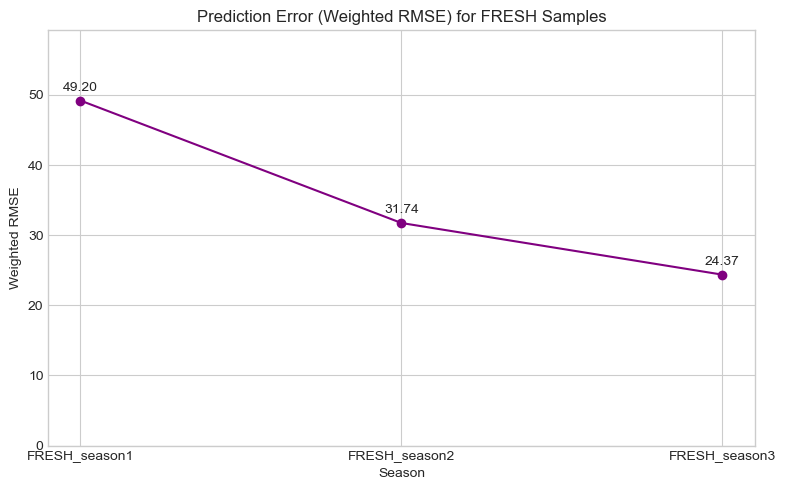

In [ ]:
# import packages 
import pandas as pd
import matplotlib.pyplot as plt

# prepare data
rpd_data = {
    "Season": [
        "DRIED_season1", "DRIED_season2", "DRIED_season3", "DRIED_season4",
        "FRESH_season1", "FRESH_season2", "FRESH_season3"
    ],
    "Weighted RMSE": [
        42.1363, 27.6439, 11.9289, 23.3960,
        49.2048, 31.7413, 24.3725
    ],
    "Average RPD (N+P+K)": [
        2.011233, 3.309933, 2.273933, 1.015600,
        1.888700, 2.653300, 1.016833
    ]
}

# 轉成DataFrame
df = pd.DataFrame(rpd_data)

# split DRIED and FRESH 
dried = df[df["Season"].str.contains("DRIED")]
fresh = df[df["Season"].str.contains("FRESH")]

#plt.style.use('seaborn-white')
plt.style.use('seaborn-v0_8-whitegrid')



# =======================
# plot DRIED samples RPD
# =======================
plt.figure(figsize=(8,5))
plt.plot(dried["Season"], dried["Average RPD (N+P+K)"], marker='o', color='orange')
plt.axhline(y=2.0, color='red', linestyle='--', label='RPD = 2.0 (Excellent)')
for i, val in enumerate(dried["Average RPD (N+P+K)"]):
    plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom')
plt.title("Prediction Performance (RPD) for DRIED Samples")
plt.xlabel("Season")
plt.ylabel("Average RPD (N, P, K)")
plt.ylim(0, max(dried["Average RPD (N+P+K)"])+1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =======================
# plot DRIED samples RMSE
# =======================
plt.figure(figsize=(8,5))
plt.plot(dried["Season"], dried["Weighted RMSE"], marker='o', color='orange')
for i, val in enumerate(dried["Weighted RMSE"]):
    plt.text(i, val + 1, f"{val:.2f}", ha='center', va='bottom')
plt.title("Prediction Error (Weighted RMSE) for DRIED Samples")
plt.xlabel("Season")
plt.ylabel("Weighted RMSE")
plt.ylim(0, max(dried["Weighted RMSE"])+10)
plt.grid(True)
plt.tight_layout()
plt.show()

# =======================
# plot FRESH samples RPD
# =======================
plt.figure(figsize=(8,5))
plt.plot(fresh["Season"], fresh["Average RPD (N+P+K)"], marker='o', color='green')
plt.axhline(y=2.0, color='red', linestyle='--', label='RPD = 2.0 (Excellent)')
for i, val in enumerate(fresh["Average RPD (N+P+K)"]):
    plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom')
plt.title("Prediction Performance (RPD) for FRESH Samples")
plt.xlabel("Season")
plt.ylabel("Average RPD (N, P, K)")
plt.ylim(0, max(fresh["Average RPD (N+P+K)"])+1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =======================
# plot FRESH samples RMSE
# =======================
plt.figure(figsize=(8,5))
plt.plot(fresh["Season"], fresh["Weighted RMSE"], marker='o', color='purple')
for i, val in enumerate(fresh["Weighted RMSE"]):
    plt.text(i, val + 1, f"{val:.2f}", ha='center', va='bottom')
plt.title("Prediction Error (Weighted RMSE) for FRESH Samples")
plt.xlabel("Season")
plt.ylabel("Weighted RMSE")
plt.ylim(0, max(fresh["Weighted RMSE"])+10)
plt.grid(True)
plt.tight_layout()
plt.show()
